In [215]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import numpy as np
from datetime import datetime
import category_encoders as ce
import warnings

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from xgboost import XGBClassifier

### Relax Data Science Challenge

Let's first do some Exploratory Data Analysis of the two csv files:

In [12]:
# takehome_user_engagement.csv: 3 columns, 207917 rows

df_user_engage = pd.read_csv('takehome_user_engagement.csv')
print(df_user_engage.shape)
df_user_engage.head()

(207917, 3)


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [6]:
num_users = df_user_engage['user_id'].nunique()
print('There are {} users in this dataset'.format(num_users))

There are 8823 users in this dataset


In [17]:
num_visits = df_user_engage['visited'].nunique()
print('There are {} visit sites in this dataset'.format(num_visits))

There are 1 visit sites in this dataset


In [7]:
# This dataset spans over approximately 2 years 

print(min(df_user_engage.time_stamp))
print(max(df_user_engage.time_stamp))

2012-05-31 08:20:06
2014-06-06 14:58:50


In [18]:
# No need for the visited column

df_user_engage.drop('visited',axis=1, inplace=True)
df_user_engage.head()

,time_stamp,user_id
0,2014-04-22 03:53:30,1
1,2013-11-15 03:45:04,2
2,2013-11-29 03:45:04,2
3,2013-12-09 03:45:04,2
4,2013-12-25 03:45:04,2


The next lines of code serve to create a column respresenting whether a user is an adopted user or not. This is done by grouping the dataframe by user_id, and resampling the login dates for each user by week.

If a user shows a count of at least 3 from at least one sample, that means the user has logged in thrice in a week, and is thus an adopted user.

In [ ]:
def is_adopted(timestamps):
    '''Takes in a list of datetimes and returns 1 if the user is adopted, 
    and 0 if the user is not adopted'''
    
    timestamps = pd.DataFrame(timestamps)
    timestamps[0] = pd.to_datetime(timestamps[0])
    timecounts = timestamps.set_index(0).sort_index().resample('1W').size()
    
    for i in timecounts:
        if i >= 3:
            return 1
    return 0

In [88]:
grouped = pd.DataFrame(df_user_engage.groupby('user_id')['time_stamp'].apply(list))
grouped_index = list(grouped.index)
grouped_timestamps = list(grouped['time_stamp'])

In [230]:
# This will create a list that will be extremely useful when creating the model

adopted_status = list(map(is_adopted,grouped_timestamps))

In [96]:
df_adopted = pd.DataFrame({'object_id':grouped_index, 'adopted':adopted_status})
df_adopted.head(10)

,object_id,adopted
0,1,0
1,2,1
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,10,1
8,11,0
9,13,0


Next, we look at the other csv file: takehome_users.csv

In [93]:
# takehome_users.csv: 10 columns, 12000 rows 

df_users = pd.read_csv('takehome_users.csv', encoding='latin-1')
print(df_users.shape)
df_users.head(10)

(12000, 10)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0


Defining an "adopted user" as a user who has logged into the product on three separate days in at least one seven­day period, identify which factors predict future user adoption.

In [100]:
df_clean = pd.merge(df_users, df_adopted, on='object_id', how='outer')
print(df_clean.shape)
df_clean.head(10)

(12000, 11)


,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0
5,6,2013-12-17 03:37:06,Cunha Eduardo,EduardoPereiraCunha@yahoo.com,GUEST_INVITE,1.387424e+09,0,0,197,11241.0,0.0
6,7,2012-12-16 13:24:32,Sewell Tyler,TylerSewell@jourrapide.com,SIGNUP,1.356010e+09,0,1,37,NaN,0.0
7,8,2013-07-31 05:34:02,Hamilton Danielle,DanielleHamilton@yahoo.com,PERSONAL_PROJECTS,NaN,1,1,74,NaN,NaN
8,9,2013-11-05 04:04:24,Amsel Paul,PaulAmsel@hotmail.com,PERSONAL_PROJECTS,NaN,0,0,302,NaN,NaN
9,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0,1.0


This dataframe needs to be preprocessed before we can use it for machine learning. For example, the email column can be edited such that it only shows the email name, which can be an important feature.

In [119]:
get_email = lambda email : email.split("@")[1].split('.')[0]
emails = list(map(get_email,df_clean['email']))
df_clean['email'] = emails
df_clean.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,yahoo,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,gustr,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,gustr,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,yahoo,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,yahoo,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [232]:
df_clean.email.nunique()

1184

The email column has 1184 address ends. Using .get_dummies() directly would add that many columns, which is computationally expensive. By using a similiar approach, the BinaryCoder, we would only have to create 11 additional columns instead.

In [182]:
df_clean_ce = df_clean.copy()
df_clean_ce.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,yahoo,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,gustr,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,gustr,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,yahoo,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,yahoo,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


In [183]:
encoder = ce.BinaryEncoder(cols=['email'])
df_clean_ce = encoder.fit_transform(df_clean_ce)
df_clean_ce.head()

,object_id,creation_time,name,email_0,email_1,email_2,email_3,email_4,email_5,email_6,...,email_9,email_10,email_11,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,0,0,0,0,0,0,0,...,0,0,1,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,0,0,0,0,0,0,0,...,0,1,0,ORG_INVITE,1.396238e+09,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,0,0,0,0,0,0,0,...,0,1,0,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,0,0,0,0,0,0,0,...,0,0,1,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,0,0,0,0,0,0,0,...,0,0,1,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0.0


The last_session_creation_time feature is in unix mode and needs to be converted

In [184]:
convert_unix = lambda x: datetime.utcfromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S')
df_clean_ce['last_session_creation_time'] = df_clean_ce['last_session_creation_time'].map(convert_unix, na_action='ignore')
df_clean_ce.head()


,object_id,creation_time,name,email_0,email_1,email_2,email_3,email_4,email_5,email_6,...,email_9,email_10,email_11,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted
0,1,2014-04-22 03:53:30,Clausen August,0,0,0,0,0,0,0,...,0,0,1,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,0,0,0,0,0,0,0,...,0,1,0,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,0,0,0,0,0,0,0,...,0,1,0,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,0,0,0,0,0,0,0,...,0,0,1,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0
4,5,2013-01-17 10:14:20,Raw Grace,0,0,0,0,0,0,0,...,0,0,1,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0


Another very useful feature could be the amount of time between the creation_time of the user (first login), and the last_session_creation_time (most recent login) 

In [185]:
df_clean_ce['creation_time'] = pd.to_datetime(df_clean_ce['creation_time'])
df_clean_ce['last_session_creation_time'] = pd.to_datetime(df_clean_ce['last_session_creation_time'])

In [186]:
nb_days = (df_clean_ce.last_session_creation_time - df_clean_ce.creation_time)/np.timedelta64(1, 'D')
df_clean_ce['nb_days'] = nb_days
df_clean_ce.head()

,object_id,creation_time,name,email_0,email_1,email_2,email_3,email_4,email_5,email_6,...,email_10,email_11,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,nb_days
0,1,2014-04-22 03:53:30,Clausen August,0,0,0,0,0,0,0,...,0,1,GUEST_INVITE,2014-04-22 03:53:30,1,0,11,10803.0,0.0,0.0
1,2,2013-11-15 03:45:04,Poole Matthew,0,0,0,0,0,0,0,...,1,0,ORG_INVITE,2014-03-31 03:45:04,0,0,1,316.0,1.0,136.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,0,0,0,0,0,0,0,...,1,0,ORG_INVITE,2013-03-19 23:14:52,0,0,94,1525.0,0.0,0.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,0,0,0,0,0,0,0,...,0,1,GUEST_INVITE,2013-05-22 08:09:28,0,0,1,5151.0,0.0,1.0
4,5,2013-01-17 10:14:20,Raw Grace,0,0,0,0,0,0,0,...,0,1,GUEST_INVITE,2013-01-22 10:14:20,0,0,193,5240.0,0.0,5.0


In [187]:
drop_cols = ['object_id', 'creation_time', 'name', 'last_session_creation_time']
df_clean_ce.drop(drop_cols, axis = 1, inplace=True)
df_clean_ce.head()

,email_0,email_1,email_2,email_3,email_4,email_5,email_6,email_7,email_8,email_9,email_10,email_11,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,nb_days
0,0,0,0,0,0,0,0,0,0,0,0,1,GUEST_INVITE,1,0,11,10803.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,1,0,ORG_INVITE,0,0,1,316.0,1.0,136.0
2,0,0,0,0,0,0,0,0,0,0,1,0,ORG_INVITE,0,0,94,1525.0,0.0,0.0
3,0,0,0,0,0,0,0,0,0,0,0,1,GUEST_INVITE,0,0,1,5151.0,0.0,1.0
4,0,0,0,0,0,0,0,0,0,0,0,1,GUEST_INVITE,0,0,193,5240.0,0.0,5.0


The get_dummies method can be used to deal with the categorical variables from the creation_source column

In [188]:
df_clean_ce = pd.get_dummies(df_clean_ce)
df_clean_ce.head()

,email_0,email_1,email_2,email_3,email_4,email_5,email_6,email_7,email_8,email_9,...,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted,nb_days,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,0,0,0,0,0,0,0,0,0,0,...,0,11,10803.0,0.0,0.0,1,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,316.0,1.0,136.0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,94,1525.0,0.0,0.0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,5151.0,0.0,1.0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,193,5240.0,0.0,5.0,1,0,0,0,0


Remove the rest of the NaN values and potential duplicate rows

In [203]:
df_clean_ce.adopted.fillna(0, inplace=True)
df_clean_ce.invited_by_user_id.fillna(0, inplace=True);

In [233]:
df_clean_ce.shape

(8399, 23)

We can now begin to fit models into our data. 

In [207]:
# Set up X and y
X = df_clean_ce.drop('adopted',axis = 1)
y = df_clean_ce['adopted']

In [228]:
# Make a function that testsout multiple models

def train_and_test_model(X, y, model, param_grid):
    '''Takes in a dataframe and prarmeter grid, splits the data, 
    and optimizes the hyperparameters for the best score through
    a grid search.
    '''
    
    with warnings.catch_warnings():
        # ignore all caught warnings
        warnings.filterwarnings("ignore")
        # execute code that will generate warnings
    
    # Create train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)
    
    # Instantiate the GridSearchCV object: model_cv
    model_cv = GridSearchCV(model, param_grid=param_grid, cv=5)
    
    # Fit the model to the training data
    model_cv.fit(X_train, y_train)
    
    # Predict the labels of the test set: y_pred
    y_pred = model_cv.predict(X_test)
    
    # This will be useful for creating our ROC curves 
    y_pred_prob = model_cv.predict_proba(X_test)[:,1]
    
    # Generate ROC curve values: fpr, tpr, thresholds
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

    # Plot ROC curve
    plt.figure()
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc(fpr,tpr))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.title('ROC Curve')
    plt.legend(loc="lower right");
    
    # Print the optimal parameters and best score
    print("Tuned Hyperparameter(s): {}".format(model_cv.best_params_))
    print("Tuned Accuracy Score: {}".format(model_cv.best_score_))
    print(classification_report(y_test, y_pred))
    
    coefs = list(model_cv.best_estimator_.coef_[0])
    df_results = pd.DataFrame()
    df_results['Features'] = X.columns.tolist()
    df_results['Logreg_Coef'] = coefs
    df_results = df_results[df_results['Logreg_Coef'] != 0].sort_values(by='Logreg_Coef', ascending = False)

    return df_results
    #plt.figure()
    #plt.barh(adopted_features['Features'],adopted_features['Logreg_Coef'])
    #plt.title("The most important factors for user adoption ")
    #plt.xlabel('Logreg Coef Magnitude')
    #plt.ylabel('Features');

Tuned Hyperparameter(s): {'C': 0.2976351441631313, 'penalty': 'l1'}
Tuned Accuracy Score: 0.9680011906533711
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      1399
         1.0       0.95      0.87      0.91       281

    accuracy                           0.97      1680
   macro avg       0.96      0.93      0.94      1680
weighted avg       0.97      0.97      0.97      1680



,Features,Logreg_Coef
16,nb_days,0.046588
17,creation_source_GUEST_INVITE,0.019698
12,opted_in_to_mailing_list,0.010169
14,org_id,0.000278
15,invited_by_user_id,-0.000004
10,email_10,-0.070684
19,creation_source_PERSONAL_PROJECTS,-0.115713
18,creation_source_ORG_INVITE,-0.187799
21,creation_source_SIGNUP_GOOGLE_AUTH,-0.289886
11,email_11,-0.383802


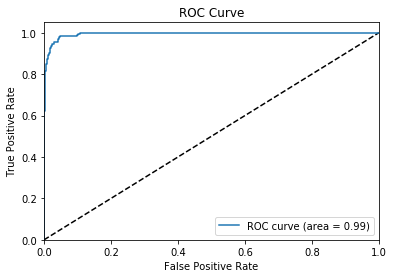

In [229]:
# Simple Logistic Regression Model

logreg = LogisticRegression(solver='liblinear')
c_space = np.logspace(-10, 8, 20) # Covers a WIDE range of possible C values
logreg_param_grid = {'C': c_space, 'penalty': ['l1', 'l2']}

train_and_test_model(X,y,logreg,logreg_param_grid)

From the results we can gather that the biggest factors that predict user adoption are: 
    - nb_days: The length of time that a user logs in. The longer a user logs in over a period of time, the more likely this user is an adopted user
    - creation_source_GUEST_INVITE: If the user was invited to the org as a guest, it's more likely this user will be an adopted user. 
    - opted_in_to_mailing_list: If the user allowed for marketing emails to be sent to him or her, it's more likely this user will be an adopted user.  